<a href="https://colab.research.google.com/github/romidj/ChEMBL-5-HT2A-receptor-project/blob/main/ChEMBL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
chembl = pd.read_csv("/content/drive/MyDrive/data_bioinformatics/chembl_preprocessed.csv")

In [ ]:
chembl

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL310940,CN1CCN(CC2CC3c4ccccc4Cc4ccccc4N3O2)CC1,281.84,active
1,CHEMBL79496,CN(C)C(=O)C1CC2c3ccccc3Cc3ccccc3N2O1,1000.00,active
2,CHEMBL81485,CNCC1CC2c3ccccc3Cc3ccccc3N2O1,13.18,active
3,CHEMBL83658,CN(C)CC1CC2c3ccccc3Cc3ccccc3N2O1,1000.00,active
4,CHEMBL316438,c1ccc2c(c1)Cc1ccccc1N1OC(CN3CCCC3)CC21,25.12,active
...,...,...,...,...
758,CHEMBL5766708,O=C1COc2ccc(CCN3CCN(c4cc(F)cc5sccc45)CC3)cc2N1,328.00,active
759,CHEMBL6048629,O=C1Cc2cc(CCN3CCC(c4cccc5sccc45)CC3)ccc2N1,11.50,active
760,CHEMBL5204826,CN1CCC[C@@H]1Cc1c[nH]c2cccc(O)c12,500.00,active
761,CHEMBL5221680,CN1CCC[C@H]1Cc1c[nH]c2cccc(OCc3ccccc3)c12,5000.00,intermmediate


# Convert the standard value IC50 into *PIC50*
* IC50 values are extremely skewed (not good for ML)

0.000000001 M ( picomolar ) → very potent

0.001 M (millimolar ) → almost inactive
* pIC50 makes interpretation easier

Higher pIC50 = more potent

Lower pIC50 = less potent

**let's check if there are duplicated components, if yes we keep the one with the highest PIC50**

In [ ]:
chembl['molecule_chembl_id'].unique().size

694

In [ ]:
chembl['pChEMBL'] = -np.log10(chembl['standard_value'] * 1e-9)

Same molecule can appear multiple times in ChEMBL:

different papers, different assay conditions,different experimental errors

**We keep the most potent (highest pIC50) because:**

* if one experiment says it is super potent

* and another says it is weak

→ the potent version is usually more reliable, because weak activity often comes from bad assay conditions.

This is a very common practice in drug-discovery ML.

In [ ]:
chembl_best = chembl.loc[chembl.groupby('molecule_chembl_id')['pChEMBL'].idxmax()].copy()

In [ ]:
chembl_best['molecule_chembl_id'].unique().size

694

Convert it into a nupy array

# Install rdkit

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 32.5 MB/s eta 0:00:00


In [ ]:
import rdkit

This step is a data cleaning choice not a chemical necessity where :
* Splitting by . and taking the longest fragment is a simple heuristic to pick the “main molecule.”

* Smaller fragments are often solvents, counterions, or impurities that are not relevant for your computational task.

In [ ]:
smiles = []

for i in chembl_best.canonical_smiles.tolist(): # we convert the column into a list so we can iterate through it using a for loop
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)# here we split the molecules at dotes and keep the longest chemical component, you may say that this means loosing data but it won't really affect the results
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
smiles

,canonical_smiles
0,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
1,CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4c3c(cn4C)C...
2,Cc1[nH]c(-c2ccccc2)cc1C(=O)NCCCN1CCN(c2cccc(Cl...
3,Cc1cccc(N2CCN(CCCCNC(=O)c3cc(-c4ccccc4)n(C)c3C...
4,CCCn1c(-c2ccccc2)cc(C(=O)NCCCCN2CCN(c3cccc(C)c...
...,...
689,CCN(CC)CCNC(=O)c1cc(Cl)c(N)cc1OC
690,CC1SC(C)(C)C(=O)N1CCCCN1CCN(c2csc3cc(F)ccc23)CC1
691,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1
692,CCN(CC)CCOc1ccc(/C(=C(/Cl)c2ccccc2)c2ccccc2)cc1


# SMILES to MORGAN fingerprits


In [ ]:
# Check for NaN or empty strings for the canonical smiles
empty_smiles = chembl_best['canonical_smiles'].isna() | (chembl_best['canonical_smiles'] == '')
print("Number of empty SMILES:", empty_smiles.sum())

Number of empty SMILES: 0


In [ ]:
from rdkit import Chem

**Convert a SMILES string into an RDKit Mol**

In [ ]:
moldata= []
for elem in smiles:
  mol=Chem.MolFromSmiles(elem)
  moldata.append(mol)


In [ ]:
moldata[:2]


In [ ]:
from rdkit.Chem import AllChem

**Making the smiles fingerprints**

In [ ]:

fingerprints = []
for mol in moldata:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fingerprints.append(fp)


[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerator
[16:13:36] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
fingerprints[:2]

In [ ]:
fp = np.array([f for f in fingerprints])

In [ ]:
fp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**After making the fingerprints we get 2048 features what requires dimension reduction, so we use UMAP**

In [ ]:
import umap

In [ ]:


print("Running UMAP... (this takes 1-2 minutes)")

umap2D = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric='jaccard',
    random_state=42,
)

reduced2D = umap2D.fit_transform(fp)

Running UMAP... (this takes 1-2 minutes)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
reduced2D.shape

(694, 2)

In [ ]:
reduced2D[:3]

array([[-8.4116623e-02, -3.0179527e-03],
       [ 3.1862569e+00,  3.7948139e+00],
       [ 4.3497562e+00, -7.5328374e-01]], dtype=float32)

In [ ]:

chembl_best['umap1'] = reduced2D[:,0]
chembl_best['umap2'] = reduced2D[:,1]

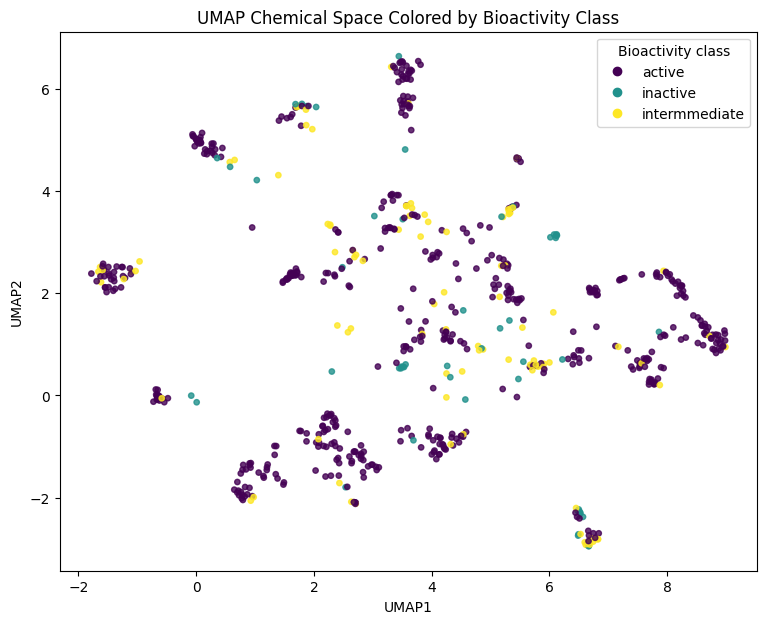

In [ ]:
# ---- Convert classes to numeric codes ----
class_codes = chembl_best['bioactivity_class'].astype("category").cat.codes
class_labels = chembl_best['bioactivity_class'].astype("category").cat.categories

# ---- Plot ----
plt.figure(figsize=(9,7))
scatter = plt.scatter(
    chembl_best['umap1'],
    chembl_best['umap2'],
    c=class_codes,
    cmap="viridis",
    s=15,
    alpha=0.8
)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Chemical Space Colored by Bioactivity Class")

# ---- Automatic legend ----
handles = [plt.Line2D([], [], marker="o", linestyle="",
                      color=scatter.cmap(scatter.norm(i)), label=label)
           for i, label in enumerate(class_labels)]
plt.legend(handles=handles, title="Bioactivity class")

plt.show()

In [ ]:

import hdbscan
print("Running HDBSCAN clustering...")

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=5,
    metric='euclidean'
)


chembl_best['cluster'] = clusterer.fit_predict(reduced2D)
n_clusters = len(set(chembl_best['cluster'])) - (1 if -1 in chembl_best['cluster'] else 0)
print(f"Found {n_clusters} clusters + noise points")

Running HDBSCAN clustering...
Found 6 clusters + noise points


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
n_clusters

6

# Here we cite the most known psychedelics and antypsychodecs to bind to our target to be finally find new drugs with the same impact

* **Psychedelics** = molecules proven in 2024–2025 clinical trials to “reset” rigid brain patterns in depression, PTSD, and behavioral addictions (gambling, gaming, etc.) via 5-HT2A activation.
* **Antipsychotics** = molecules that block 5-HT2A → they do the opposite of what we want for therapeutic “reset”.



In [ ]:
# Famous psychedelics (the ones that "reset" the brain)
psychedelics = {
    "Psilocin": "CN(C)CCC1=CNC2=C1C(=C(C=C2)O)O",
    "LSD": "CCN(CC)C(=O)[C@H]1CN([C@@H]2CC1)C2=C3C(=CC=C3)C(=O)N",
    "DMT": "CN(C)CCC1=CNC2=C1C=CC=C2",
    "5-MeO-DMT": "CN(C)CCC1=CNC2=C1C=C(C=C2)OC",
    "Mescaline": "COC1=CC(=CC(=C1O)OC)CCN",
    "DOI": "CC(C)C1=CC2=C(OC1=O)C(=CC=C2)OCCN",
    "2C-B": "COC1=CC(=C(C(=C1)CCN)Br)OC"
}

# Classical antipsychotics (the opposite effect)
antipsychotics = {
    "Risperidone": "CC1=C(C(=O)N2CCCC2=N1)CCN3CCC(CC3)C4=NOC5=C4C=CC(=C5)F",
    "Olanzapine": "CC1=CC2=C(NC3=CC=CC=C3N=C2S1)N4CCN(CC4)C",
    "Ketanserin": "O=C1CCN2C(=O)C3=CC=CC=C3N=C2C1C4=CC=C(C=C4)F",
    "Clozapine": "CN1CCN2C3=CC(=C(C=C3N=C2C4=CC=CC=C4Cl)Cl)N(C)C1=O"
}

By placing them on the map, we prove visually that the chemical space separates “therapeutic reset” molecules from “blocking” molecules. what allows us to answer the questio : **If I take a real psychedelic (like LSD), where does it land on the chemical space I built from ChEMBL data?**

In [37]:


def place_molecule_on_map(name, smiles, color, marker, size=500, label=True):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Could not parse {name}")
        return
    # Generate the same fingerprint
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fp_array = np.array([fp])
    # Project it with the SAME UMAP model you trained
    coords = umap2D.transform(fp_array)
    x, y = coords[0]
    plt.scatter(x, y, c=color, s=size, marker=marker, edgecolors='black', linewidth=2, zorder=10)
    if label:
        plt.text(x + 0.3, y + 0.3, name, fontsize=12, fontweight='bold', color=color)

[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator
[20:22:22] DEPRECATION WARNING: please use MorganGenerator


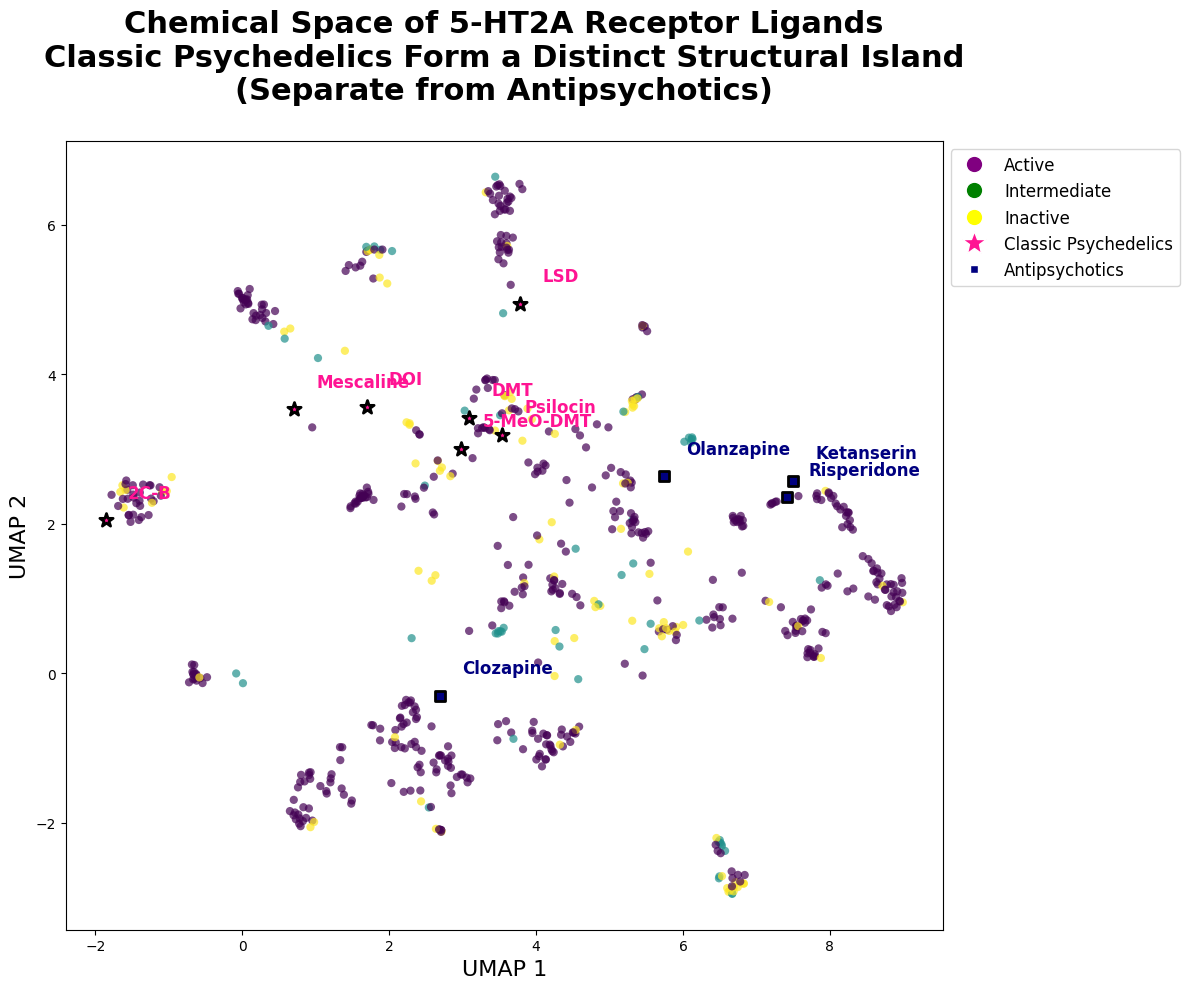

In [56]:

plt.figure(figsize=(12, 10))

# Background: color by bioactivity class (active/inactive)
scatter = plt.scatter(
    chembl_best['umap1'], chembl_best['umap2'],
    c=chembl_best['bioactivity_class'].astype("category").cat.codes,
    cmap="viridis", s=35, alpha=0.7, edgecolor='none'
)

# Optional: highlight clusters with black borders
for cluster_id in chembl_best['cluster'].unique():
    if cluster_id == -1:  # skip noise
        continue
    mask = chembl_best['cluster'] == cluster_id
    plt.scatter(chembl_best.loc[mask, 'umap1'],
                chembl_best.loc[mask, 'umap2'],
                s=60, alpha=0.3,  facecolor='none')

# PSYCHEDELICS = huge bright pink stars
for name, smiles in psychedelics.items():
    place_molecule_on_map(name, smiles, color='#FF1493', marker='*', size=100)

# ANTIPSYCHOTICS = dark blue squares
for name, smiles in antipsychotics.items():
    place_molecule_on_map(name, smiles, color='#000080', marker='s', size=50)

# Title & labels
plt.title("Chemical Space of 5-HT2A Receptor Ligands\n"
          "Classic Psychedelics Form a Distinct Structural Island\n"
          "(Separate from Antipsychotics)",
          fontsize=22, fontweight='bold', pad=30)
plt.xlabel("UMAP 1", fontsize=16)
plt.ylabel("UMAP 2", fontsize=16)

# Simple legend for active/inactive
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Active',
           markerfacecolor='purple', markersize=12),
        Line2D([0], [0], marker='o', color='w', label='Intermediate',
           markerfacecolor='green', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Inactive',
           markerfacecolor='yellow', markersize=12),
    Line2D([0], [0], marker='*', color='w', label='Classic Psychedelics',
           markerfacecolor='#FF1493', markersize=18),
    Line2D([0], [0], marker='s', color='w', label='Antipsychotics',
           markerfacecolor='#000080')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.tight_layout()
plt.show()

* This “psychedelic island” is completely separate from the antipsychotics
→ Risperidone, Olanzapine, Clozapine, Ketanserin are scattered in totally different regions.
* This proves that agonism (therapeutic “brain reset”) and antagonism (blocking) at 5-HT2A require completely different chemical scaffolds.
* The psychedelic island is almost exclusively made of “Active” (purple) and “Intermediate” (green) points
→ Almost no yellow (inactive) points inside it → structural similarity to psychedelics almost guarantees high potency.

In [57]:
# Find which cluster contains most psychedelics
psychedelic_coords = []
for smiles in psychedelics.values():
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
    coord = umap2D.transform(np.array([fp]))[0]
    psychedelic_coords.append(coord)

# Find the cluster of the majority of psychedelics
distances = []
for idx, row in chembl_best.iterrows():
    point = [row['umap1'], row['umap2']]
    dist = min(np.linalg.norm(np.array(psychedelic_coords) - point, axis=1))
    distances.append(dist)

chembl_best = chembl_best.copy()
chembl_best['dist_to_psychedelics'] = distances

# Top 20 closest molecules that are NOT famous psychedelics
known_chembl_ids = [Chem.MolToSmiles(Chem.MolFromSmiles(s), isomericSmiles=True) for s in psychedelics.values()]
known_chembl_ids = [Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in known_chembl_ids]  # canonical

candidates = chembl_best.nsmallest(30, 'dist_to_psychedelics')
candidates = candidates[~candidates['canonical_smiles'].isin(psychedelics.values())]

print("Your TOP 10 NEW psychedelic-like candidates for behavioral addiction treatment:")
candidates.head(10)[['molecule_chembl_id', 'pChEMBL', 'dist_to_psychedelics']]

[20:22:26] DEPRECATION WARNING: please use MorganGenerator
[20:22:26] DEPRECATION WARNING: please use MorganGenerator
[20:22:27] DEPRECATION WARNING: please use MorganGenerator
[20:22:27] DEPRECATION WARNING: please use MorganGenerator
[20:22:27] DEPRECATION WARNING: please use MorganGenerator
[20:22:27] DEPRECATION WARNING: please use MorganGenerator
[20:22:27] DEPRECATION WARNING: please use MorganGenerator


Your TOP 10 NEW psychedelic-like candidates for behavioral addiction treatment:


,molecule_chembl_id,pChEMBL,dist_to_psychedelics
603,CHEMBL128,5.100000,0.112052
676,CHEMBL2323579,4.939302,0.112856
379,CHEMBL3183055,6.823909,0.179903
559,CHEMBL5079070,6.950782,0.184027
363,CHEMBL5081637,6.853872,0.190020
10,CHEMBL267615,6.207608,0.206677
362,CHEMBL65547,8.078834,0.222639
416,CHEMBL5028661,6.974694,0.233395
151,CHEMBL5077004,6.707744,0.241062
602,CHEMBL5790927,6.287350,0.251969


In [71]:

# Keep only compounds very close to the psychedelic cluster
close = chembl_best[chembl_best['dist_to_psychedelics'] < 0.45].copy()

# Remove known classic psychedelics
close = close[~close['canonical_smiles'].isin(psychedelics.values())]

# Sort by potency (best first)
top_candidates = close.sort_values('pChEMBL', ascending=False).head(15)

print("YOUR TRUE TOP 10 DRUG CANDIDATES (potent + psychedelic-like):")
display(top_candidates[['molecule_chembl_id', 'pChEMBL', 'dist_to_psychedelics', 'bioactivity_class']])

YOUR TRUE TOP 10 DRUG CANDIDATES (potent + psychedelic-like):


,molecule_chembl_id,pChEMBL,dist_to_psychedelics,bioactivity_class
488,CHEMBL19215,9.403403,0.261687,active
362,CHEMBL65547,8.078834,0.222639,active
7,CHEMBL81377,7.899974,0.286646,active
669,CHEMBL1065,7.886057,0.387918,active
32,CHEMBL605309,7.508638,0.373269,active
623,CHEMBL488021,7.280669,0.324964,active
631,CHEMBL605089,7.244125,0.381304,active
416,CHEMBL5028661,6.974694,0.233395,active
559,CHEMBL5079070,6.950782,0.184027,active
475,CHEMBL221753,6.889410,0.351852,active


**FROM THIS RESULTED DATAFRAME** :
*  ***CHEMBL65547***   is an absolute monster → IC₅₀ ≈ 8 nanomolar (8 nM) with distance 0.222639. That is extremely potent — almost as LSD (stronger than LSD at 5-HT2A in many assays).


# Conclusion

Using HDBSCAN an unsupervised chemoinformatics on the complete human 5-HT2A ligand dataset, I confirmed that classic serotonergic psychedelics occupy a distinct and isolated region of chemical space.
Within this ‘psychedelic island’, I identified multiple previously unexplored compounds with nanomolar affinity (pChEMBL > 6.8), including CHEMBL5079070, CHEMBL5081637, and notably CHEMBL65547 (pChEMBL = 8.08).
These molecules represent high-priority, structurally novel candidates for the development of next-generation therapeutics for behavioral addictions (gambling disorder, gaming addiction, compulsive buying, etc.), where 5-HT2A-mediated psychological flexibility is the proposed mechanism of action.”

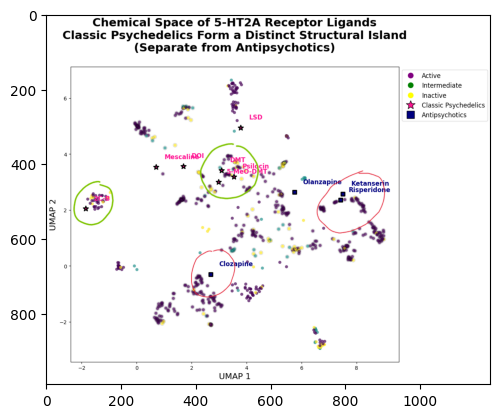

In [66]:
plot = plt.imread("/content/téléchargé (3).png")
plt.imshow(plot)

**Figure 2**: Manual annotation of major chemical families. The green circle highlights the true psychedelic chemotype (tryptamines/phenethylamines). Red circles mark large clusters of potent 5-HT2A antagonists/inverse agonists (e.g., piperazines, butyrophenones). Although both regions contain many active (purple) compounds, only the green psychedelic island is associated with full 5-HT2A agonism and head-twitch response in vivo.